In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
os.chdir("../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [3]:
# load the pHopt values
data_opt = pd.read_csv("inputs/brenda/ph_opt_data_no_assay_at_no_mutant.tsv", sep='\t')
print(data_opt.uniprot_id.nunique(), len(data_opt))
data_opt.head(2)

6777 8367


,ec_num,uniprot_id,opt,species,references,comments
0,1.1.1.1,D4GSN2,11.0,Haloferax volcanii,"7011375,3816781,2789998,22526808","#82# oxidation of ethanol, pyrazole-insensitiv..."
1,1.1.1.1,D4GSN2,6.0,Haloferax volcanii,"12834271,16000771,17072683,16390205,16243283,1...","#96,122# reduction of acetaldehyde <144,255>; ..."


In [12]:
enzyme_type = {1: "Oxidoreductases",
 2: "Transferases",
 3: "Hydrolases",
 4: "Lyases",
 5: "Isomerases",
 6: "Ligases",
 7: "Translocases"}

In [4]:
oxidoreductase_acceptor = {
    1: "NAD+ or NADP+",
    2: "cytochrome",
    3: "oxygen",
    4: "disulfide",
    5: "quinone",
    6: "nitrogenous group",
    7: "iron-sulfur protein",
    8: "flavin group",
    9: "copper protein",
}

In [14]:
sub_type = {
    "Oxidoreductases": {
        1: "CH-OH group of donors",
        2: "aldehyde or oxo group of donors",
        3: "CH-CH group of donors",
        4: "CH-NH2 group of donors",
        5: "CH-NH group of donors",
        6: "NADH or NADPH",
        7: "other nitrogenous compounds as donors",
        8: "sulfur group of donors",
        9: "heme group of donors",
        10: "diphenols and related substances as donors",
        11: "peroxide as acceptor",
        12: "hydrogen as donor",
        13: "oxygenases",
        14: "paired donors, with molecular oxygen",
        15: "superoxide as acceptor",
        16: "Oxidizing metal ions",
        17: "CH or CH2 groups",
        18: "iron-sulfur proteins as donors",
        19: "reduced flavodoxin as donor",
        20: "phosphorus or arsenic in donors",
        21: "Catalysing the reaction X-H + Y-H = X-Y",
        22: "halogen in donors",
        23: "Reducing C-O-C group as acceptor",
    },

    "Transferases": {
        1: "one-carbon groups",
        2: "aldehyde or ketonic groups",
        3: "Acyltransferases",
        4: "Glycosyltransferases",
        5: "alkyl or aryl groups, other than methyl groups",
        6: "nitrogenous groups",
        7: "phosphorus-containing groups",
        8: "sulfur-containing groups",
        9: "selenium-containing groups",
        10: "molybdenum- or tungsten-containing groups",
    },

    "Hydrolases": {
        1: "ester bonds",
        2: "Glycosylases",
        3: "ether bonds",
        4: "peptide bonds (peptidases)",
        5: "carbon-nitrogen bonds, other than peptide bonds",
        6: "acid anhydrides",
        7: "carbon-carbon bonds",
        8: "halide bonds",
        9: "phosphorus-nitrogen bonds",
        10: "sulfur-nitrogen bonds",
        11: "carbon-phosphorus bonds",
        12: "sulfur-sulfur bonds",
        13: "carbon-sulfur bonds",
    },

    "Lyases": {
        1: "Carbon-carbon",
        2: "Carbon-oxygen",
        3: "Carbon-nitrogen",
        4: "Carbon-sulfur",
        5: "Carbon-halide",
        6: "Phosphorus-oxygen",
        7: "Carbon-phosphorus",
        8: "Nitrogen-oxygen",
    },

    "Isomerases": {
        1: "Racemases and epimerases",
        2: "cis-trans-Isomerases",
        3: "Intramolecular oxidoreductases",
        4: "Intramolecular transferases",
        5: "Intramolecular lyases",
        6: "Isomerases altering macromolecular conformation",
    },

    "Ligases": {
        1: "carbon-oxygen bonds",
        2: "carbon-sulfur bonds",
        3: "carbon-nitrogen bonds",
        4: "carbon-carbon bonds",
        5: "phosphoric-ester bonds",
        6: "nitrogen—metal bonds",
        7: "nitrogen-nitrogen bonds",
    },

    "Translocases": {
        1: "hydrons",
        2: "inorganic cations",
        3: "inorganic anions and their chelates",
        4: "amino acids and peptides",
        5: "carbohydrates and their derivatives",
        6: "other compounds",
    },
}

In [16]:
data_opt['enzyme_type'] = data_opt.ec_num.apply(lambda x: enzyme_type[int(x.split('.')[0])])
data_opt['enzyme_type_sub'] = data_opt.ec_num.apply(lambda x: sub_type[enzyme_type[int(x.split('.')[0])]].get(int(x.split('.')[1]), 'other'))
data_opt.head(2)

,ec_num,uniprot_id,opt,species,references,comments,enzyme_type,opt_mean,enzyme_type_sub
0,1.1.1.1,D4GSN2,11.0,Haloferax volcanii,"7011375,3816781,2789998,22526808","#82# oxidation of ethanol, pyrazole-insensitiv...",Oxidoreductases,11.0,CH-OH group of donors
1,1.1.1.1,D4GSN2,6.0,Haloferax volcanii,"12834271,16000771,17072683,16390205,16243283,1...","#96,122# reduction of acetaldehyde <144,255>; ...",Oxidoreductases,6.0,CH-OH group of donors


In [10]:
# for each uniprot ID, take the average pH as the optimum
data_opt['opt_mean'] = data_opt.opt.apply(lambda x: np.mean([float(x.split('-')[0]), float(x.split('-')[1])])  if '-' in x else x)
data_opt['opt_mean'] = data_opt['opt_mean'].astype(float)

In [17]:
data_opt.enzyme_type.value_counts()

Hydrolases         3209
Oxidoreductases    2131
Transferases       1660
Lyases              747
Isomerases          372
Ligases             184
Translocases         64
Name: enzyme_type, dtype: int64

In [6]:
data_opt['enzyme_type'] = data_opt.ec_num.apply(lambda x: enzyme_type[int(x.split('.')[0])])
data_opt.head(2)

,ec_num,uniprot_id,opt,species,references,comments,enzyme_type
0,1.1.1.1,D4GSN2,11.0,Haloferax volcanii,"7011375,3816781,2789998,22526808","#82# oxidation of ethanol, pyrazole-insensitiv...",oxidoreductases
1,1.1.1.1,D4GSN2,6.0,Haloferax volcanii,"12834271,16000771,17072683,16390205,16243283,1...","#96,122# reduction of acetaldehyde <144,255>; ...",oxidoreductases


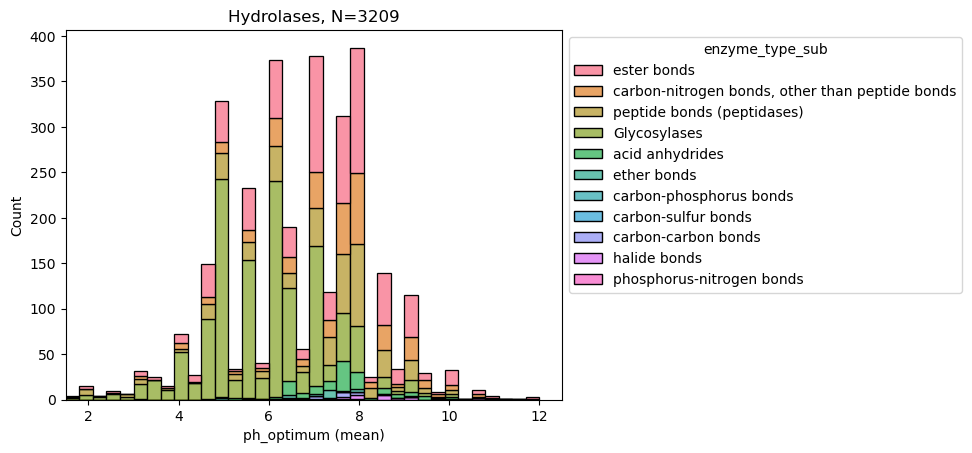

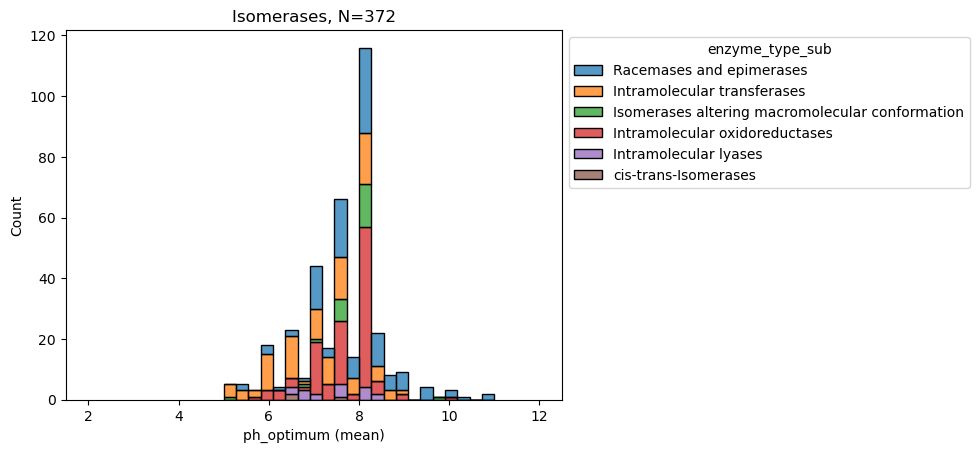

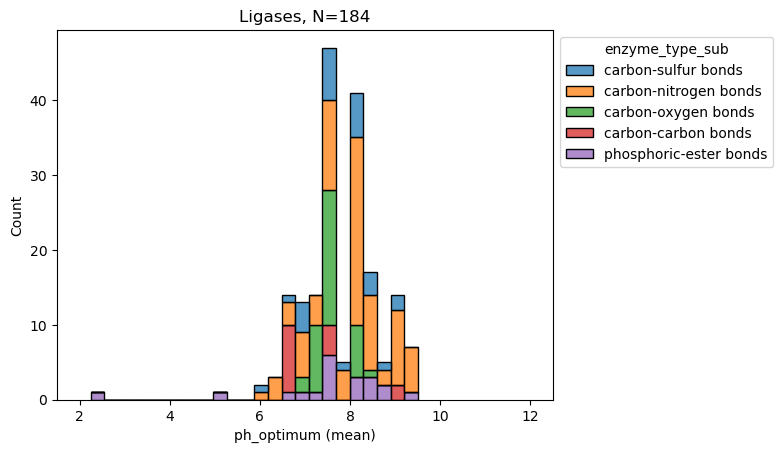

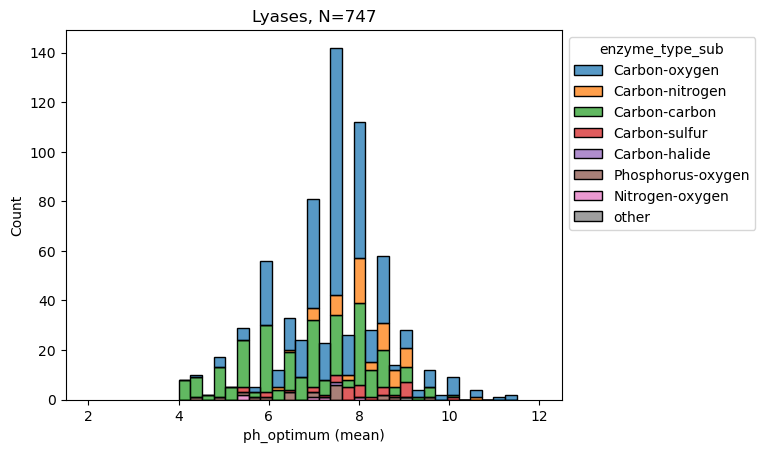

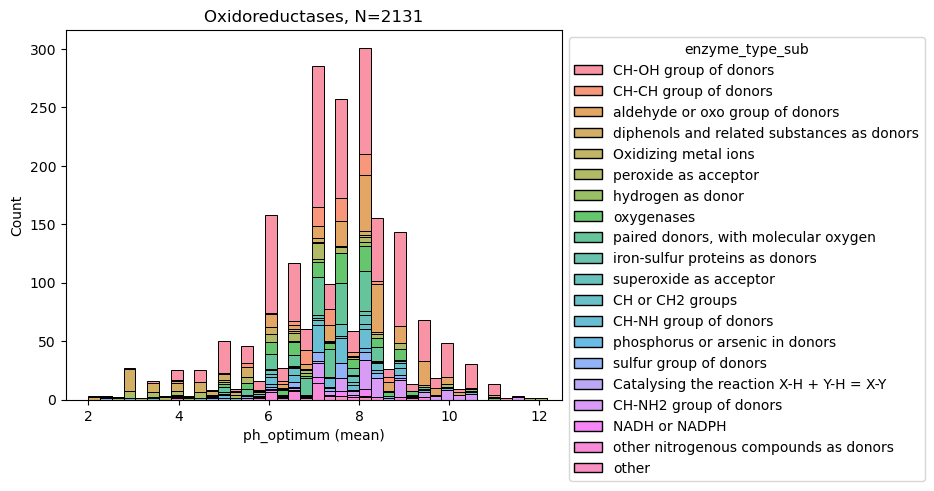

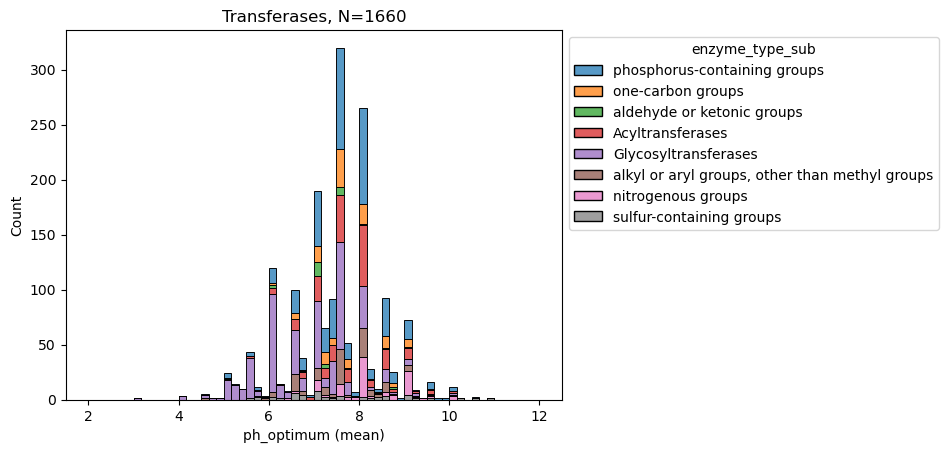

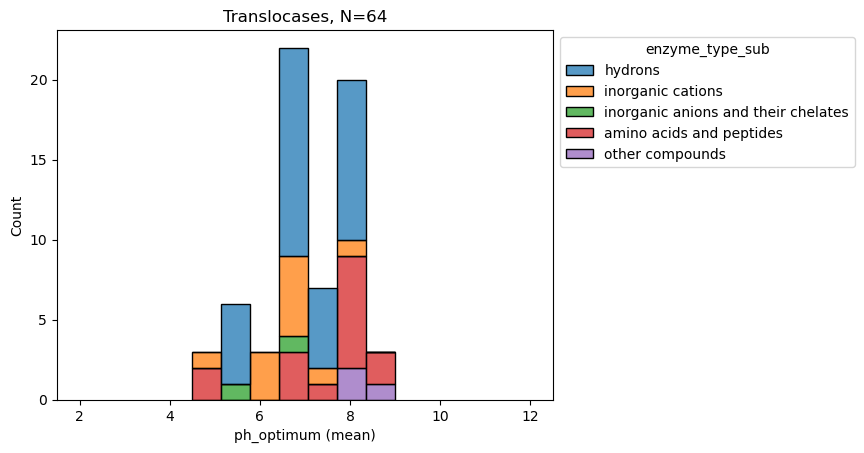

In [22]:
for e_type, df in data_opt.groupby('enzyme_type'):
    f, ax = plt.subplots()
    sns.histplot(data=df, x='opt_mean', ax=ax,
                 hue='enzyme_type_sub',
                 multiple="stack",
                )
    ax.set_xbound(1.5, 12.5)
    # df.opt_mean.plot.hist(bins=30)
    ax.set_title(f"{e_type}, N={len(df)}")
    ax.set_xlabel("ph_optimum (mean)")
    # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()

## Separate oxidoreductase reactions into oxidase and reductase
- Reductase reactions are easier at low pH because hydrogen atoms are more abundant, and oxidase reactions are easier at high pH because it's easier to remove a hydrogen.
- To tell the difference, we should be able to use the cofactor(s) listed. 
  - E.g., if NADH is the cofactor, then it's used to reduce the substrate. 
  - If NAD+ is the cofactor, it should be an oxidizing reaction

In [ ]:
# get the cofactor(s) listed for each reference and each organism/protein

In [3]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict

In [4]:
import os
# os.chdir("../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [5]:
brenda_file = "/projects/robustmicrob/jlaw/inputs/brenda/brenda_2022_2.json"
brenda_dict = json.load(open(brenda_file))

In [6]:
list(brenda_dict['data'].keys())[-5:]

['7.6.2.5', '7.6.2.6', '7.6.2.7', '7.6.2.8', '7.6.2.9']

In [8]:
inputs_dir = "inputs/brenda"

In [18]:
# load the pH range and opt values
data_file = Path(inputs_dir, "ph_range/20230719_ph_range_processed.csv")
print(data_file)
data = pd.read_csv(data_file, index_col=0)
print(len(data))

act_file = Path(inputs_dir, "ph_range/20230719_ph_range_processed_act_wopt.csv")
print(act_file)
data_act = pd.read_csv(act_file)
data_act['uniprot_id'] = data_act.exp_index.apply(lambda x: data.loc[x].uniprot_id)
print(len(data_act))
data_act.head(2)

inputs/brenda/ph_range/20230719_ph_range_processed.csv
5842
inputs/brenda/ph_range/20230719_ph_range_processed_act_wopt.csv
6341


,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5...",B2KJ46
1,0,4.5,1.0,NaN,NaN,B2KJ46


In [13]:
# # This file has the ph range data + optimum ph data
# data_file = Path(inputs_dir, "20230726_ph_activity_data_merged.csv")
# # This file has the ph range data 
# # data_file = Path(inputs_dir, "20230726_ph_range_data_merged.csv")
# data_act_merged = pd.read_csv(data_file)
# data_act_merged.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,0.0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5...",B2KJ46
1,0.0,4.5,1.0,NaN,NaN,B2KJ46


In [20]:
data.head()

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
2,1.1.1.1,A4IP64,Geobacillus thermodenitrificans,6.0,9.0,"11893392,19383697",None
3,1.1.1.1,Q9HIM3,Thermoplasma acidophilum,2.0,8.0,19058034,None
4,1.1.1.1,P00330,Saccharomyces cerevisiae,5.5,9.0,21670533,"reduction reaction activity range, profile ov..."


In [24]:
data_act['ec_num'] = data_act.exp_index.apply(lambda i: data.loc[int(i)].ec_num)
redox_rows = data_act[data_act.ec_num.apply(lambda ec: ec.split('.')[0] == "1")]
print(redox_rows.uniprot_id.nunique(), len(redox_rows))
redox_rows.head(2)

491 1549


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,ec_num
0,0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5...",B2KJ46,1.1.1.1
1,0,4.5,1.0,NaN,NaN,B2KJ46,1.1.1.1


In [39]:
def get_redox_type_from_comment(comment):
    if comment is None or pd.isna(comment):
        return np.nan
    if 'oxidation' in comment and 'reduction' in comment:
        print(comment)
        return np.nan
    if 'oxidation' in comment:
        return 'oxidation' 
    elif 'reduction' in comment:
        return 'reduction' 
    else:
        return np.nan
redox_rows['rxn_type'] = redox_rows.note.apply(get_redox_type_from_comment)
print(len(redox_rows.dropna(subset=['rxn_type'])))

87


/tmp/ipykernel_34489/1639523556.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  redox_rows['rxn_type'] = redox_rows.note.apply(get_redox_type_from_comment)


In [50]:
redox_rows.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,ec_num,rxn_type
0,0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5...",B2KJ46,1.1.1.1,NaN
1,0,4.5,1.0,NaN,NaN,B2KJ46,1.1.1.1,NaN


In [48]:
# example = brenda_dict['data']['1.1.1.85']
example = brenda_dict['data']['4.1.1.101']
example['cofactor']

[{'comment': '#4# Km value 0.045 mM <3>; #5# Km value 0.13 mM <4>; #1# Km value 59 mM <15>; #3,4,5# presence of NAD+ required <8>; #6# required, Km value 0.00045 mM <13>; #5# required, Km value 0.044 mM <14>',
  'organisms': ['4', '3', '6', '1', '5'],
  'references': ['3', '4', '8', '13', '14', '15'],
  'value': 'NAD+'}]

In [49]:
# TODO not all entries have pmid
def get_references(ec_dict):
    references = {}
    for ref_id, data in ec_dict['references'].items():
        if 'pmid' not in data:
            continue
        # print(data)
        references[ref_id] = str(data['pmid'])
    return references
get_references(example)

{'1': '22452826',
 '2': '23446978',
 '3': '16345941',
 '4': '16346657',
 '5': '8919788',
 '6': '10427020',
 '7': '23835171',
 '9': '21404095',
 '11': '8405453',
 '12': '7867919',
 '13': '6536648',
 '14': '2097345',
 '15': '6833282',
 '16': '24929730',
 '17': '27348346',
 '18': '29998731'}

In [20]:
data.head()

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
2,1.1.1.1,A4IP64,Geobacillus thermodenitrificans,6.0,9.0,"11893392,19383697",None
3,1.1.1.1,Q9HIM3,Thermoplasma acidophilum,2.0,8.0,19058034,None
4,1.1.1.1,P00330,Saccharomyces cerevisiae,5.5,9.0,21670533,"reduction reaction activity range, profile ov..."


In [69]:
def get_brenda_cofactors(row):
    ec_data = brenda_dict['data'][row.ec_num]
    if 'cofactor' not in ec_data or pd.isna(row.references):
        return np.nan
    
    cofactors = []
    for cofactor_dict in ec_data['cofactor']:
        cofactor = cofactor_dict['value']
        ref_dict = get_references(ec_data)
        references = [ref for idx, ref in ref_dict.items() if idx in cofactor_dict['references']]
        for ref in row.references.split(','):
            if ref in references:
                cofactors += [cofactor]
    # if len(cofactors) > 0:
    return cofactors

# data_test = data[data.ec_num == "1.1.1.85"]
# data_test['cofactors'] = data_test.apply(get_brenda_cofactors, axis=1)
# data_test.head(2)
data['cofactors'] = data.apply(get_brenda_cofactors, axis=1)
data.head(2)

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,cofactors
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"pH 4.0: about 80% of maximal activity, pH 7.5...",[]
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"pH 7: 41% of maximal activity, pH 8: 59% of m...",[]


5842 2155


<AxesSubplot: ylabel='Frequency'>

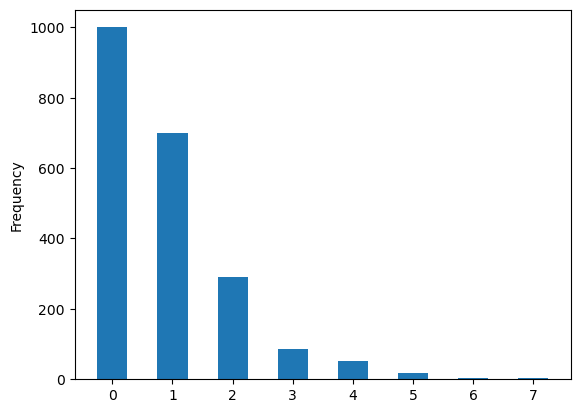

In [79]:
print(len(data), len(data.dropna(subset='cofactors')))
data.dropna(subset='cofactors').cofactors.apply(len).plot.hist(bins=np.arange(-0.25,7.5,.5))

1351 1073


<AxesSubplot: ylabel='Frequency'>

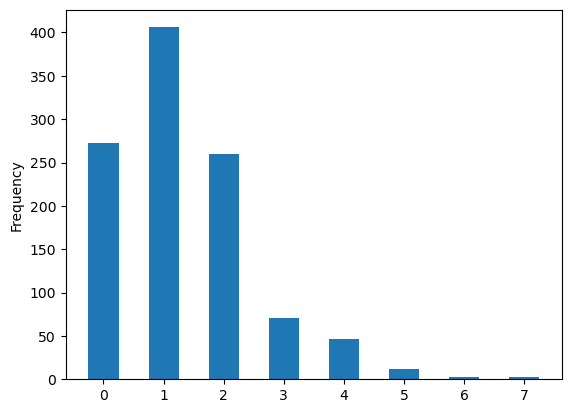

In [89]:
print(len(redox_rows), len(redox_rows.dropna(subset='cofactors')))
redox_rows = redox_rows.dropna(subset='cofactors')
redox_rows.cofactors.apply(len).plot.hist(bins=np.arange(-0.25,7.5,.5))

In [83]:
redox_rows[redox_rows.ec_num == "1.1.1.85"]

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,cofactors
3171,1.1.1.85,P04173,Saccharomyces cerevisiae,7.5,11.5,6993484,about 75% of maximal activity at pH 7.5 and 1...,[NAD+]
3172,1.1.1.85,P04173,Saccharomyces cerevisiae,8.0,10.1,3071718,"pH 8.0: 75% of maximal activity, pH 8.9-10.1:...",[NAD+]


In [92]:
redox_rows.cofactors.value_counts().head(40)

[]                                                    272
[NAD+]                                                 95
[FAD]                                                  72
[NADPH]                                                71
[NAD+, NADH]                                           58
[NADP+]                                                31
[heme]                                                 30
[NADH]                                                 25
[flavin]                                               23
[NADPH, NADP+]                                         21
[NADH, NAD+]                                           21
[NADPH, NADH]                                          20
[NAD+, NADP+]                                          19
[NADP+, NADPH]                                         12
[NADPH, FAD]                                           12
[NADH, NADPH]                                          12
[NADP+, NAD+]                                          11
[Ferredoxin, A

In [95]:
redox_rows[redox_rows.cofactors.apply(lambda x: 'heme' in x)].head(10)

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,cofactors,redox_type
245,1.1.99.18,B6D1P2,Gelatoporia subvermispora,2.5,6.5,19270118,None,"[heme, FAD]",NaN
246,1.1.99.18,B6D1P2,Gelatoporia subvermispora,2.5,4.5,19270118,"lactose as substrate, cytochrome c as electro...","[heme, FAD]",NaN
247,1.1.99.18,Q01738,Phanerodontia chrysosporium,3.5,6.0,"20709172,26003328,33407462",None,"[heme, FAD, FAD, FAD, heme b]",NaN
250,1.1.99.18,Q01738,Phanerodontia chrysosporium,3.0,6.0,"24315647,33407462,33063604",None,"[heme, FAD, FAD]",NaN
251,1.1.99.18,S5R9V1,Cerrena unicolor,3.5,6.0,"20709172,26003328,33407462",None,"[heme, FAD, FAD, FAD, heme b]",NaN
254,1.1.99.18,S5RVR8,Trametes sanguinea,3.0,6.0,"24315647,33407462,33063604",None,"[heme, FAD, FAD]",NaN
276,1.11.1.11,A4ZYP9,Cenchrus americanus,5.0,7.8,19450902,activity 35 units mg-1 protein min-1 at pH 5....,[heme],NaN
285,1.11.1.19,Q47KB1,Thermobifida fusca YX,3.0,4.0,19967355,None,[heme],NaN
286,1.11.1.19,T1SP91,Saccharomonospora viridis,4.0,9.0,25333297,the enzyme shows more than 35% activity at pH...,[heme],NaN
293,1.11.1.6,A5XB38,Haliotis discus discus,4.5,10.5,18187341,above 90% of maximum activity,"[heme, NADPH]",reduction


In [93]:
def get_redox_type_from_cofactors(cofactors):
    if len(cofactors) == 0:
        return np.nan
    if ('NAD+' in cofactors or 'NADP+' in cofactors) and \
       ('NADH' not in cofactors and 'NADPH' not in cofactors and 'NAD(P)H' not in cofactors):
        return 'oxidation'
    # if flavin and FAD are paired with another cofactor, it's NADH or NADPH. May mean that it's used for reducing
    if ('NADH' in cofactors or 'NADPH' in cofactors or 'NAD(P)H' in cofactors) and \
       ('NAD+' not in cofactors and 'NADP+' not in cofactors):
        return 'reduction'
    # if the redox type is not clear, return np.nan for now
    return np.nan

redox_rows['redox_type'] = redox_rows.cofactors.apply(get_redox_type_from_cofactors)
redox_rows.redox_type.value_counts()

reduction    208
oxidation    167
Name: redox_type, dtype: int64

In [96]:
redox_rows

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,cofactors,redox_type
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"pH 4.0: about 80% of maximal activity, pH 7.5...",[],NaN
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"pH 7: 41% of maximal activity, pH 8: 59% of m...",[],NaN
2,1.1.1.1,A4IP64,Geobacillus thermodenitrificans,6.0,9.0,"11893392,19383697",None,"[NAD+, NADH, NADP+]",NaN
3,1.1.1.1,Q9HIM3,Thermoplasma acidophilum,2.0,8.0,19058034,None,[NAD+],oxidation
4,1.1.1.1,P00330,Saccharomyces cerevisiae,5.5,9.0,21670533,"reduction reaction activity range, profile ov...","[NAD+, NADH]",NaN
...,...,...,...,...,...,...,...,...,...
3656,1.8.98.1,P96796,Methanosarcina barkeri,5.0,7.5,8174566,activity with reduced benzyl viologen and N-(...,"[cytochrome b, FAD]",NaN
3657,1.8.98.1,P96797,Methanosarcina barkeri,5.0,7.5,8174566,activity with reduced benzyl viologen and N-(...,"[cytochrome b, FAD]",NaN
3658,1.9.6.1,Q56350,Paracoccus pantotrophus,7.0,9.5,8119278,"pH 7.0: about 70% of maximal activity, pH 9.5...","[cytochrome c552, heme]",NaN
3659,1.9.6.1,B5FGW1,Aliivibrio fischeri,5.5,10.0,13412117,sharp drop of activity below pH 5.5 and above...,[cytochrome],NaN


In [102]:
data_act['redox_type'] = data_act.exp_index.apply(lambda x: redox_rows.loc[x].redox_type if x in redox_rows.index else np.nan)
data_act.dropna(subset='redox_type').head()

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,ec_num,redox_type
23,13,9.0,1.00,NaN,NaN,Q5JI09,1.1.1.1,oxidation
24,13,3.0,1.00,NaN,NaN,Q5JI09,1.1.1.1,oxidation
25,13,6.0,0.50,for reduction of aldehydes,50% of maximum activity for reduction of alde...,Q5JI09,1.1.1.1,oxidation
32,19,8.0,1.00,NaN,NaN,Q8VIJ7,1.1.1.105,oxidation
33,19,7.5,0.54,pH 8: maximal activity,"pH 7.5: 54% of maximal activity, pH 8: maxima...",Q8VIJ7,1.1.1.105,oxidation


In [104]:
data_act['ec_num'] = data_act.exp_index.apply(lambda i: data.loc[int(i)].ec_num)
act_redox_rows = data_act[data_act.ec_num.apply(lambda ec: ec.split('.')[0] == "1")]
print(act_redox_rows.uniprot_id.nunique(), len(act_redox_rows))
act_redox_rows.head(2)

491 1549


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,ec_num,redox_type
0,0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5...",B2KJ46,1.1.1.1,NaN
1,0,4.5,1.0,NaN,NaN,B2KJ46,1.1.1.1,NaN


In [105]:
def get_redox_type_from_comment(comment):
    if comment is None or pd.isna(comment):
        return np.nan
    if 'oxidation' in comment and 'reduction' in comment:
        print(comment)
        return np.nan
    if 'oxidation' in comment:
        return 'oxidation' 
    elif 'reduction' in comment:
        return 'reduction' 
    else:
        return np.nan
act_redox_rows['rxn_type'] = act_redox_rows.note.apply(get_redox_type_from_comment)
print(len(act_redox_rows.dropna(subset=['rxn_type'])))

87


/tmp/ipykernel_34489/3384906158.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_redox_rows['rxn_type'] = act_redox_rows.note.apply(get_redox_type_from_comment)


In [106]:
act_redox_rows.dropna(subset=['redox_type', 'rxn_type'])

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,ec_num,redox_type,rxn_type
25,13,6.0,0.5,for reduction of aldehydes,50% of maximum activity for reduction of alde...,Q5JI09,1.1.1.1,oxidation,reduction
267,179,12.0,0.6,"within this range for reduction of D-xylulose,...",over 60% of maximal activity within this rang...,A0A141BGH5,1.1.1.9,oxidation,reduction
268,179,10.0,0.6,"within this range for reduction of D-xylulose,...",over 60% of maximal activity within this rang...,A0A141BGH5,1.1.1.9,oxidation,reduction
3959,3416,7.0,0.9,"methylmalonate semialdehyde oxidation, above a...","methylmalonate semialdehyde oxidation, less t...",Q02253,1.2.1.27,oxidation,oxidation
3960,3416,8.5,0.9,"methylmalonate semialdehyde oxidation, above a...","methylmalonate semialdehyde oxidation, less t...",Q02253,1.2.1.27,oxidation,oxidation
3961,3417,9.5,0.5,"propanal oxidation, above and below","propanal oxidation, less than 50% of maximal ...",Q02253,1.2.1.27,oxidation,oxidation
3962,3417,8.0,0.5,"propanal oxidation, above and below","propanal oxidation, less than 50% of maximal ...",Q02253,1.2.1.27,oxidation,oxidation
3963,3418,7.0,0.9,"methylmalonate semialdehyde oxidation,","methylmalonate semialdehyde oxidation, more t...",P28810,1.2.1.27,oxidation,oxidation
3964,3418,10.0,0.9,"methylmalonate semialdehyde oxidation,","methylmalonate semialdehyde oxidation, more t...",P28810,1.2.1.27,oxidation,oxidation
3965,3419,10.0,0.6,"propanal oxidation, below, above","propanal oxidation, less than 50% of maximal ...",P28810,1.2.1.27,oxidation,oxidation


In [107]:
data.loc[179]

ec_num                                                  1.1.1.9
uniprot_id                                           A0A141BGH5
species                                   Gluconobacter oxydans
ph_min                                                     10.0
ph_max                                                     12.0
references                                             26975753
comments       over 60% of maximal activity within this rang...
cofactors                                                [NAD+]
Name: 179, dtype: object

In [108]:
data[data.uniprot_id == "A0A141BGH5"]

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,cofactors
178,1.1.1.9,A0A141BGH5,Gluconobacter oxydans,4.0,8.0,"13654257,26975753",None,"[NAD+, NAD+, NADH]"
179,1.1.1.9,A0A141BGH5,Gluconobacter oxydans,10.0,12.0,26975753,over 60% of maximal activity within this rang...,[NAD+]


In [107]:
data.loc[179]

ec_num                                                  1.1.1.9
uniprot_id                                           A0A141BGH5
species                                   Gluconobacter oxydans
ph_min                                                     10.0
ph_max                                                     12.0
references                                             26975753
comments       over 60% of maximal activity within this rang...
cofactors                                                [NAD+]
Name: 179, dtype: object

In [ ]:
acceptors = set(['NAD+', 'FAD', 'NADP+'])

In [85]:
cofactors = set(c for c_list in redox_rows.cofactors.dropna().values for c in c_list)
print(cofactors)

{'NADH', 'riboflavin', 'adrenodoxin', '[2Fe-2S] cluster', 'flavin', 'NAD(P)H', '2-oxoglutarate', 'tetrahydrobiopterin', '2,4,5-trihydroxyphenylalaninequinone', 'thio-NADP+', 'heme c', 'Fe-S center', '[2Fe-2S]-center', 'Cys-Tyr cofactor', 'thiamine diphosphate', '2,4,5-trihydroxyphenylalanine quinone', 'ubiquinone', 'cytochrome P-450', 'ATP', 'ferredoxin-NADP+-oxidoreductase', 'Cobalamin', 'iron-sulfur centre', 'nicotinamide guanine dinucleotide', 'thionicotinamide-NAD+', 'FMN', 'molybdenum cofactor', 'tetrahydropteridine', '3-acetyl-pyridine adenine dinucleotide', 'glutathione', 'CoA', 'linoleoyl-CoA', 'ferricytochrome c', '2,6-dichlorophenolindophenol', 'dithiothreitol', 'form A cofactor', 'corrinoid', '[4Fe-4S]-center', 'cytochrome', 'tungsten-molybdopterin', 'FAD', 'N6-carboxymethyl-NAD+', 'thioredoxin', 'cytochrome b5', 'ascorbate', 'cytochrome b', 'cytochrome cL', 'Ferredoxin', 'cytochrome P450', 'coenzyme A', 'thio-NAD+', 'NAD+', 'FMNH2', 'NADPH', '3-acetylpyridine adenine dinucl

In [110]:
brenda_dict['data']['1.1.1.9']['ph_range']

[{'comment': '#1# about 75% of maximal reduction activity at pH 4.0 and 8.0 <1>; #14# reduction reaction, activity range <50>; #36# over 60% of maximal activity within this range for oxidation of xylitol, profile overview <63>',
  'proteins': ['36'],
  'organisms': ['1', '36', '14'],
  'references': ['1', '50', '63'],
  'min_value': 4.0,
  'max_value': 8.0},
 {'comment': '#11# about 80% of maximal oxidation activity at pH 8.7 and 10.5 <8>',
  'organisms': ['11'],
  'references': ['8'],
  'min_value': 8.7,
  'max_value': 10.5},
 {'comment': '#14# oxidation reaction, activity range <50>',
  'organisms': ['14'],
  'references': ['50'],
  'min_value': 9.0,
  'max_value': 12.0},
 {'comment': '#14# over 60% of maximal activity within this range <67>',
  'organisms': ['14'],
  'references': ['67'],
  'min_value': 11.0,
  'max_value': 13.0},
 {'comment': '#16# fully active <21>',
  'organisms': ['16'],
  'references': ['21'],
  'min_value': 9.0,
  'max_value': 10.0},
 {'comment': '#32# over 50